In [1]:
## Setup dependencies
%matplotlib inline
%matplotlib widget
from matplotlib import style
style.use('fivethirtyeight')

#To allow multiple screen outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import pretty print for cleaner screen output
from pprint import pprint

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement).order_by(measurement.date.desc()).first().date
most_recent_date

'2017-08-23'

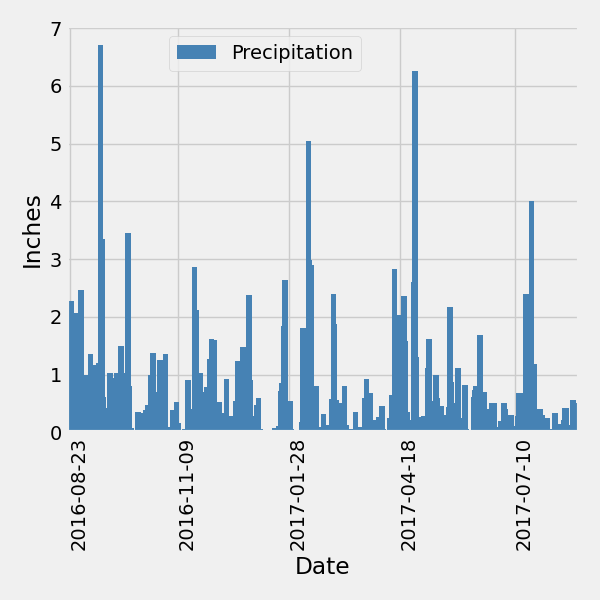

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d").date()
one_year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
one_year_query = session.query(measurement.date.desc(), measurement.prcp).\
                         filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
one_year_df = pd.DataFrame(one_year_query, columns=['Date','Precipitation'])

# Sort the dataframe by date (& precipitation)
one_year_df = one_year_df.sort_values(by = ['Date','Precipitation'])
one_year_df = one_year_df.reset_index(drop=True)

#--------------------------------------------------------------------------
# Use Pandas Plotting with Matplotlib to plot the data

## Minimize data set to maximum values by date for plotting
one_year_df_max = one_year_df.copy()
one_year_df_max['Precipitation'] = one_year_df_max.groupby('Date')['Precipitation'].\
                                                   transform('max')
one_year_df_max = one_year_df_max.drop_duplicates()

## Configure plot type, color, plot size, bar width, and axis labels
figure1 = one_year_df_max.plot(kind="bar", 
                               color="steelblue", 
                               figsize=(6,6), 
                               width=4.0,
                               xlabel="Date",
                               ylabel="Inches")

# Configure x-ticks & rotation, legend placement
xticklabels = ['2016-08-23',
               '2016-11-09',
               '2017-01-28',
               '2017-04-18',
               '2017-07-10']
figure1.set_xticks([0,78,158,238,321])
figure1.set_xticklabels(xticklabels, rotation=90, rotation_mode="anchor", ha="right", wrap=True)
plt.legend(loc = (0.2, 0.89))

# Show plot
plt.tight_layout()
plt.savefig('image_output/Last_12_Mos_Precip_All.png')
plt.show();

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
one_year_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
with engine.connect() as conn:
    print(conn.execute(text('SELECT count(distinct measurement.station) FROM measurement')).fetchall())

##Alternative method
num_stations = session.query(measurement.station).distinct().count()
num_stations

[(9,)]


9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, 
                                func.count(measurement.station)).\
                          group_by(measurement.station).\
                          order_by(func.count(measurement.station).desc()).\
                          all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

low_hi_avg = session.query(func.min(measurement.tobs),
                           func.max(measurement.tobs),
                           func.avg(measurement.tobs)).\
                     filter(measurement.station == most_active_station).\
                     all()

print(f"The most active station is {most_active_station} with a ")
print(f"low temp of {low_hi_avg[0][0]}°F,")
print(f"high temp of {low_hi_avg[0][1]}°F, and an ")
print(f"average temp of {low_hi_avg[0][2]}°F.")

The most active station is USC00519281 with a 
low temp of 54.0°F,
high temp of 85.0°F, and an 
average temp of 71.66378066378067°F.


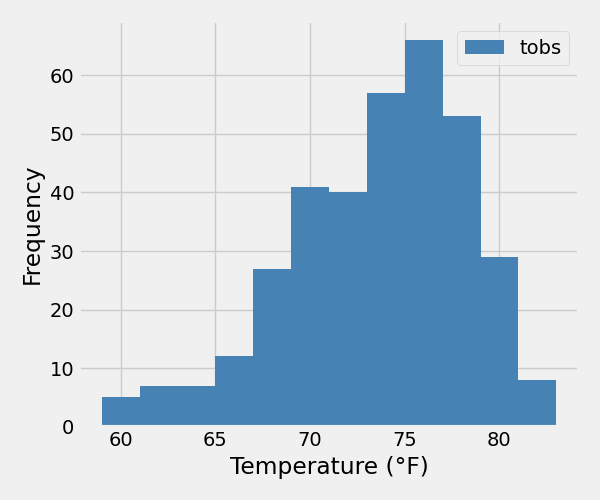

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_twelve = session.query(measurement.date, measurement.tobs).\
                      filter(measurement.date >= one_year_ago).\
                      filter(measurement.station == most_active_station).\
                      order_by(measurement.date).\
                      all()

# Save query results to Pandas DF
last_12_df = pd.DataFrame(last_twelve)

## Configure plot, figsize, title, and axis labels
figure1 = last_12_df.plot(kind="hist", 
                          color="steelblue", 
                          figsize=(6,5), 
                          width=2.0, 
                          bins = 12,
                          xlabel="Temperature (°F)",
                          ylabel="Frequency")
plt.tight_layout()
plt.savefig('image_output/Last_12_Mos_USC00519281.png')
plt.show();

# Close Session

In [36]:
# Close Session
session.close()